In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd

Using TensorFlow backend.
W1106 15:38:15.626125  1352 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
data_folder = '../Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [3]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

from deephydro.utils import limit_gpu_memory
limit_gpu_memory()

W1106 15:38:15.869126  1352 deprecation_wrapper.py:119] From C:\Users\vinograd\Documents\deephydro\DeepHydro\src\deephydro\utils.py:29: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1106 15:38:15.870125  1352 deprecation_wrapper.py:119] From C:\Users\vinograd\Documents\deephydro\DeepHydro\src\deephydro\utils.py:33: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



# Data import

- load output data

In [4]:
import platform
platform.system()

'Windows'

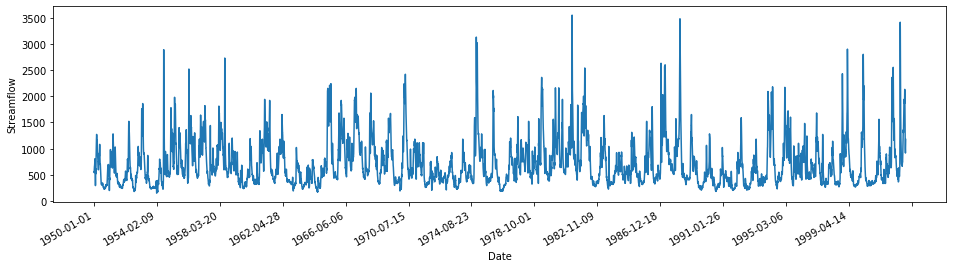

In [5]:
from deephydro import data, visualization
df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)
df.head()
visualization.plot_streamflow(df=df, n_labels=20)

- load input data

In [6]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [7]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


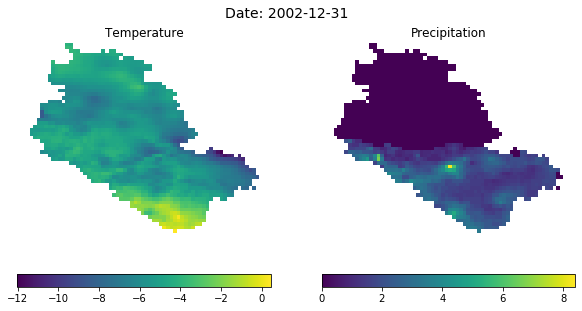

In [8]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, 
                                   frame=-1)


# Data preparation

- define input data `x` and targets `y`

In [9]:
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df['FDOY'].values

# y: streamflow data
y = df['Q'].values

- split train and validation data

In [10]:
# split train and validation data
validation_fraction=0.2
validation_first=False

x_train, x_val, y_train, y_val = \
  data.split_train_validation(x, y, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

x_doy_train, x_doy_val = data.split_DOY_train_validation(x_doy,  
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

df_train, df_val = data.split_df_train_validation(df, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)


In [11]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (15487, 53, 66, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 53, 66, 2)
Shape of y_val   =  (3871,)


- standardize input (`x_train`) and output data (`y`)

In [12]:
x_train = data.standardize_input_data(x_train)
x_val   = data.standardize_input_data(x_val)

In [13]:
y_train, (Y_MEAN, Y_STD) = data.standardize_targets(y_train)
y_val = (y_val - Y_MEAN) / Y_STD

In [14]:
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y_train = ', y_train.shape)

Y_MEAN = 715.437
Y_STD  = 426.762
Shape of y_train =  (15487,)


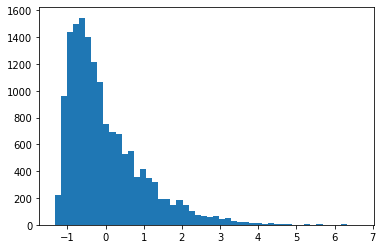

In [15]:
_ = plt.hist(y_train, bins=50)

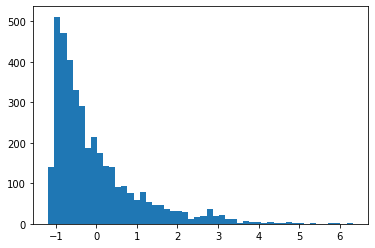

In [16]:
_ = plt.hist(y_val, bins=50)

## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [17]:
# length of image sequence
n_frames = 70
# number of GPUs
n_gpus = 1#6

if n_gpus > 1:
    # check if this number of GPUs is available
    import keras.backend as K
    assert n_gpus <= len(K.tensorflow_backend._get_available_gpus())
    
# adjust this to available GPU memory (VRAM)
batch_size = 92*n_gpus

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = True


In [18]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()


W1106 15:38:25.141254  1352 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1106 15:38:25.142220  1352 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [19]:
from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train,
                                         doy=x_doy_train, day_of_year=day_of_year,
                                         batch_size=batch_size, n_frames=n_frames,
                                         stride=1)
generator_val  = ImageSequenceGenerator(data=x_val, labels=y_val,   
                                         doy=x_doy_val, day_of_year=day_of_year,
                                         batch_size=batch_size, n_frames=n_frames,
                                         stride=1)

In [20]:
batch = generator_train.__getitem__(0)
if day_of_year:
    print(f'Shape of batch_x im  = {batch[0][0].shape}')
    print(f'Shape of batch_x doy = {batch[0][1].shape}')
    print(f'Shape of batch_y     = {batch[1].shape}')
else:
    print(f'Shape of batch_x = {batch[0].shape}')
    print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x = (92, 70, 53, 66, 2)
Shape of batch_y = (92,)


- the `tensorboard()` callback requires validation_data to be given as fixed data instead of a `generator_val`. Therefore, we create a validation dataset `validation_data` here. Unfortunately, this will involve a lot of redundant/copied data. 

In [21]:
# use 1/3 of validation set for validation
n_validation_data = len(x_val)//3
iterator = range(0, n_validation_data, 1)
validation_data_x = []
validation_data_y = []
for start in iterator:
    end = start+n_frames
    validation_data_x.append(x_val[start:end])
    validation_data_y.append(y_val[end-1])
        
validation_data_x = np.array(validation_data_x)
print(validation_data_x.shape)
validation_data_y = np.array(validation_data_y)
print(validation_data_y.shape)
validation_data = (validation_data_x, validation_data_y)

(1290, 70, 53, 66, 2)
(1290,)


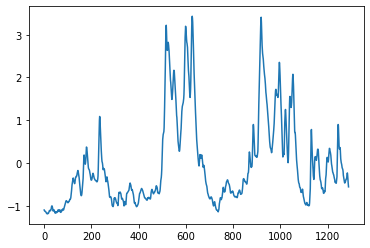

In [22]:
plt.plot(validation_data_y)

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [23]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
# model = networks.nowcasting_model(input_shape, n_filters=16, dayofyear=day_of_year,
#                                   dropout_rate=0.5, 
#                                   batch_norm=True,
#                                   conv2D_preprocessing=True)
model = networks.nowcasting_uncertainty_model(input_shape, n_filters=16, dayofyear=day_of_year,
                                  dropout_rate=0.5, 
                                  batch_norm=True,
                                  conv2D_preprocessing=False)


model.summary(line_length=120)

W1106 15:38:31.682220  1352 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1106 15:38:32.965255  1352 deprecation.py:506] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
images (InputLayer)                    (None, 70, 53, 66, 2)      0                                                     
________________________________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)            (None, 70, 26, 32, 16)     10432         images[0][0]                            
________________________________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)            (None, 70, 12, 15, 32)     55424         conv_lst_m2d_1[0][0]                    
________________________________________________________________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)     

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

- compile model: loss, optimizer and metrics

In [24]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

def build_model(model, 
                loss,
                metrics=ccc,
                optimizer=optimizers.Adam(lr=1e-4), 
                n_gpus:int=1):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model
        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model


# Training

In [ ]:
n_epochs = 20

In [ ]:
from deephydro.utils import checkpointer, early_stopping, reduce_learning_rate, tensorboard
model_name = '../output/model_wdb_uncertainty_noDOY_NOWcasting_slowlearning_tensorboard.h5'
callbacks = [checkpointer(model_name), 
             reduce_learning_rate()]
             #early_stopping()]
             #tensorboard()]


In [ ]:
if n_gpus > 1:
    parallel_model = build_model(model, loss=gauss, n_gpus=n_gpus)
    parallel_model.summary(line_length=120)
    history = parallel_model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation # tensorboard histograms does not accept generator
                              validation_data=validation_data,
                              ## validation
                              #validation_data=generator_val,
                              #validation_steps=len(x_val)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              use_multiprocessing=False,
                              #workers=2, # if too large, you'll get CPU memory issues (job gets killed)
                              #max_queue_size=10
                              )
else:
    model = build_model(model, loss=mse, n_gpus=n_gpus)
    model.summary(line_length=120)
    history = model.fit_generator(
                              # training
                              generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              # validation
                              validation_data=generator_val,
                              validation_steps=len(x_val)//batch_size,
                              # callbacks
                              callbacks=callbacks,
                              # CPU parallelism 
                              #use_multiprocessing=False,
                              #workers=12,
                              #max_queue_size=10
                              )

In [ ]:
from deephydro import visualization
visualization.plot_history(history)

Everything except model plotting works for Kira. 17.10.19

# Predict

-----

**To do predictions, please use the [predict.ipynb]('./predict.ipynb') notebook.**

-----


In [ ]:
#model_name = '../output/model_wdb_uncertainty.h5'

In [ ]:
reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    from deephydro.losses import gauss
    model = load_model(model_name, 
               custom_objects={'ccc': ccc, 'gauss': gauss})

In [ ]:
x_val.shape

- predict time series

In [ ]:
Y_MEAN

In [ ]:
Y_STD

In [ ]:
from deephydro.inference import predict_timeseries

maxtime = len(x_val) // 3 # len(x_val) // 20
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data=x_val[:maxtime], 
                                    doy=None, #x_doy_val[:maxtime], 
                                    df=df_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size=256, 
                                    Y_MEAN=Y_MEAN, Y_STD=Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True,
                                    uncertainty=True,
                                    T=10,
                                    n_gpus=n_gpus)

In [ ]:
from deephydro.inference import predict_timeseries

maxtime = len(x_val) # len(x_val) // 20
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data=x_val[:maxtime], 
                                    doy=None, #x_doy_val[:maxtime], 
                                    df=df_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size=256, 
                                    Y_MEAN=Y_MEAN, Y_STD=Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True,
                                    uncertainty=True,
                                    T=10,
                                    n_gpus=6)

In [ ]:
from deephydro.visualization import plot_streamflow
plot_streamflow(df_pred, n_labels=20, filename="../output/streamflow_predicted_full2.pdf", figsize=(32,4))
#df_pred

In [ ]:
df_pred.head()

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(df_pred['Q'], df_pred['Q_pred'], y_pred_sigma=df_pred['Q_pred_sigma'], filename="../output/concordance_correlation_full2.pdf")

In [ ]:
df_pred.head()

In [ ]:
df_pred.to_csv('../output/df_pred.csv')

- predict random samples

In [ ]:
from deephydro.utils import predict_batch
gt, y_pred = predict_batch(model, generator=generator_val, 
                     n_samples=2000, y_mean=Y_MEAN, y_std=Y_STD)

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(gt, y_pred)

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [25]:
model_name = '../output/model_wdb_doy_nobatchnorm_dropout.h5' #model_wdb_log_dropout_batchnorm.h5'

n_frames = 70
Y_MEAN = 715.437
Y_STD  = 426.762

reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    model = load_model(model_name, 
               custom_objects={'ccc': ccc})

W1106 15:38:51.729516  1352 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1106 15:38:52.528555  1352 deprecation.py:323] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
# get a batch of images
batch = generator_val.__getitem__(0)
# select a single image
im = batch[0][12]

In [34]:
type(batch)

tuple

In [36]:
im_tuple=tuple(np.array(batch[0][12],batch[1][12]))

In [27]:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\vinograd\anaconda3_12\envs\tf_for_hydro\lib\site-packages
Requires: wheel, tensorflow-estimator, numpy, protobuf, tensorboard, grpcio, six, termcolor, keras-preprocessing, keras-applications, astor, gast, google-pasta, absl-py, wrapt
Required-by: 


!pip install shap

In [50]:
model.layers[0].input.shape

TensorShape([Dimension(None), Dimension(70), Dimension(53), Dimension(66), Dimension(2)])

In [48]:
import shap
import numpy as np
def saliency_map(model, generator, image, background_batches=2):
    
    

    # select a set of background examples to take an expectation over
    # this takes the mean over a number of batches of inputs images
    background = np.mean(np.array([np.mean(generator.__getitem__(0)[0], axis=0) for _ in range(background_batches)]), axis=0)
    print(background.shape,background[np.newaxis, ...].shape,np.array([background[np.newaxis, ...],0.5]).shape)
    
    # explain predictions
    #e = shap.DeepExplainer(model, np.array([background[np.newaxis, ...],[0.5]]))
    # ...or pass tensors directly
    e = shap.DeepExplainer((model.layers[0].input[0], model.layers[-1].output), background)#[np.newaxis, ...])
    """
    classshap.DeepExplainer(model, data, session=None, learning_phase_flags=None)
Meant to approximate SHAP values for deep learning models.

    shap_values(X, ranked_outputs=None, output_rank_order='max')
Return approximate SHAP values for the model applied to the data given by X.

X :list,
if framework == ‘tensorflow’: numpy.array.
"""
    shap_values = e.shap_values(image[np.newaxis, ...])[0][0]

    return shap_values
shap = saliency_map(model, generator=generator_val, image=im_tuple)
print(shap.shape)

(70, 53, 66, 2) (1, 70, 53, 66, 2) (2,)


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'day_of_year' with dtype float and shape [?,1]
	 [[node day_of_year (defined at C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:517) ]]
	 [[dense_15_1/concat/_1015]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'day_of_year' with dtype float and shape [?,1]
	 [[node day_of_year (defined at C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:517) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'day_of_year':
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-4b5c4b5c67ef>", line 13, in <module>
    custom_objects={'ccc': ccc})
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\saving.py", line 419, in load_model
    model = _deserialize_model(f, custom_objects, compile)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\saving.py", line 225, in _deserialize_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\saving.py", line 458, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\layers\__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\utils\generic_utils.py", line 145, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\network.py", line 1022, in from_config
    process_layer(layer_data)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\network.py", line 1008, in process_layer
    custom_objects=custom_objects)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\layers\__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\utils\generic_utils.py", line 147, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\base_layer.py", line 1109, in from_config
    return cls(**config)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\engine\input_layer.py", line 87, in __init__
    name=self.name)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)

In [ ]:
batch[1]

In [ ]:
batch[0].shape

In [ ]:
len(batch)

In [ ]:
shap.DeepExplainer.shap_values